In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from tensorflow import keras

def prepare_data(seq,num):
  x=[]
  y=[]
  for i in range(0,(len(seq)-num),1):
    
    input_ = seq[i:i+num]
    output  = seq[i+num]
    
    x.append(input_)
    y.append(output)
    
  return np.array(x), np.array(y)

data=pd.read_csv('../Utilities\csv\metrics_2024-09-09\metrics.csv')
print(data.head)
cpu_usage = data['value'].values

num=80 # The first 20 mins of traffic
sample = cpu_usage[:num]

x,y= prepare_data(cpu_usage,num)
print(len(x))

ind = int(0.7 * len(x))
x_tr = x[:ind]
y_tr = y[:ind]
x_val=x[ind:]
y_val=y[ind:]

#normalize the inputs
x_scaler= StandardScaler()
x_tr = x_scaler.fit_transform(x_tr)
x_val= x_scaler.transform(x_val)

#reshaping the output for normalization
y_tr=y_tr.reshape(len(y_tr),1)
y_val=y_val.reshape(len(y_val),1)

#normalize the output
y_scaler=StandardScaler()
y_tr = y_scaler.fit_transform(y_tr)[:,0]
y_val = y_scaler.transform(y_val)[:,0]

#reshaping input data
x_tr= x_tr.reshape(x_tr.shape[0],x_tr.shape[1],1)
x_val= x_val.reshape(x_val.shape[0],x_val.shape[1],1)
print(x_tr.shape)

def traffic_prediction_lstm():
    model = Sequential()
    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), input_shape=(num, 1)))
    # Additional LSTM layers
    model.add(LSTM(40, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
    model.add(LSTM(30, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
    # Batch Normalization
    model.add(BatchNormalization())
    # Dense layer with ReLU activation
    model.add(Dense(30, activation='relu'))
    # Output layer for regression
    model.add(Dense(1, activation='linear'))
    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    # Learning Rate Scheduler
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    # Print model summary
    model.summary()
    return model, lr_scheduler


lstm_model, lr_scheduler = traffic_prediction_lstm()
# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = lstm_model.fit(x_tr, y_tr,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping, lr_scheduler])

mse = lstm_model.evaluate(x_val,y_val)
print("Mean Square Error:",mse)

#build a simple model
def compute_moving_average(data):
  pred=[]
  for i in data:
    avg=np.sum(i)/len(i)
    pred.append(avg)
  return np.array(pred)
x_reshaped = x_val.reshape(-1,num)
y_pred = compute_moving_average(x_reshaped)
mse = np.sum ( (y_val - y_pred) **2 ) / (len(y_val))
print("Mean Square Error:",mse)

<bound method NDFrame.head of                 timestamp      value
0     07/09/2024 14:00:00   0.011945
1     07/09/2024 14:00:15   0.011945
2     07/09/2024 14:00:30   0.011803
3     07/09/2024 14:00:45   0.020707
4     07/09/2024 14:01:00   0.023311
...                   ...        ...
2156  07/09/2024 22:59:00  35.503632
2157  07/09/2024 22:59:15  35.503632
2158  07/09/2024 22:59:30  34.938319
2159  07/09/2024 22:59:45  34.684105
2160  07/09/2024 23:00:00  33.630746

[2161 rows x 2 columns]>
2081
(1456, 80, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirecti  (None, 80, 100)           20800     
 onal)                                                           
                                                                 
 lstm_10 (LSTM)              (None, 80, 40)            22560     
                                                               

1/1 [==============================] - 0s 69ms/step


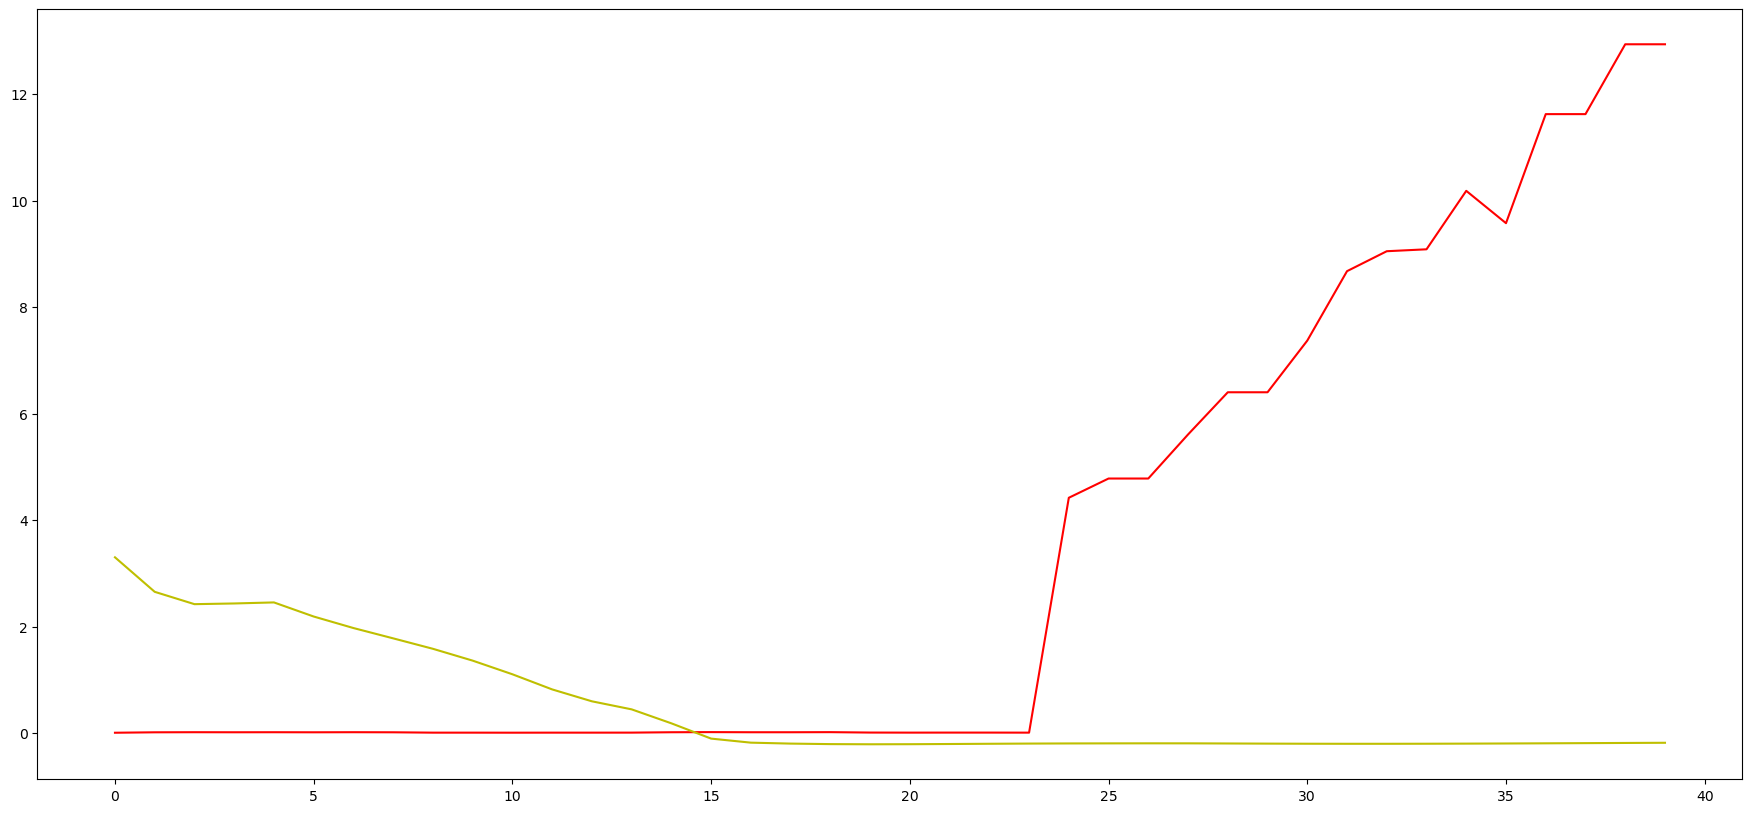

In [27]:
def forecast(x_val, no_of_pred, ind):
  predictions=[]
  #intialize the array with a weeks data
  temp=x_val[ind]
  for i in range(no_of_pred):
    #predict for the next hour
    pred=lstm_model.predict(temp.reshape(1,-1,1))[0][0]
    
    #append the prediction as the last element of array
    temp = np.insert(temp,len(temp),pred)
    predictions.append(pred)
    #ignore the first element of array
    temp = temp[1:]
  return np.array(predictions)

no_of_pred = 40
ind = 240
y_pred= forecast(x_val,no_of_pred,ind).reshape(-1, 1)
y_true = y_val[ind:ind+(no_of_pred)].reshape(-1, 1)

# Lets convert back the normalized values to the original dimensional space
y_true= y_scaler.inverse_transform(y_true)
y_pred= y_scaler.inverse_transform(y_pred)

def plot(y_true,y_pred):
  ar = np.arange(len(y_true))
  plt.figure(figsize=(22,10))
  plt.plot(ar, y_true,'r')
  plt.plot(ar, y_pred,'y')
  plt.show()
plot(y_true,y_pred)